Now trying SU(3).

In [1]:
import numpy as np
import pandas as pd

# Setup plotting with matplotlib
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
## setup latex plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
## make font size bigger
matplotlib.rcParams.update({'font.size': 16})
## but make legend smaller
matplotlib.rcParams.update({'legend.fontsize': 14})
## change line thickness
matplotlib.rcParams.update({'lines.linewidth' : 1.75})

# SKLearn
from sklearn.manifold import TSNE

# Tensorflow Keras
# from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import tensorflow.keras.metrics as metrics
import tensorflow.keras.losses as losses
from tensorflow import one_hot 

from keras import backend as K
import tensorflow as tf

In [2]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Some useful functions

n_components = np.arange(0, 8, 1)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    pca_scores = []
    for n in n_components:
        pca.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
    return pca_scores 

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Useful to find random orthogonal vectors
def find_orth(O):
    rand_vec = np.random.rand(O.shape[0], 1)
    A = np.hstack((O, rand_vec))
    b = np.zeros(O.shape[1] + 1)
    b[-1] = 1
    return np.linalg.lstsq(A.T, b)[0]

In [3]:
import random

# More useful functions

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
liststrucSU3 = np.array([[1,2,3,1],[1,4,7,.5],[1,5,6,-.5],[2,4,6,.5],[2,5,7,.5],[3,4,5,.5],[3,6,7,-.5],[4,5,8,3**0.5/2],[6,7,8,3**0.5/2]])
liststrucSU2 = np.array([[1,2,3,1],[3,2,1,1]])

def adjointSUN(dim,liststruc):
    dimSUN=dim**2-1
#     admat = np.zeros((8,8,8))
    admat = np.zeros((dimSUN,dimSUN,dimSUN))
    for i in range(liststruc.shape[0]):
        strucc = liststruc[i]
        strucc1 = int(strucc[0])-1
        strucc2 = int(strucc[1])-1
        strucc3 = int(strucc[2])-1
        admat[strucc1,strucc2,strucc3]=strucc[3]
        admat[strucc1,strucc3,strucc2]=-strucc[3]
        admat[strucc3,strucc1,strucc2]=strucc[3]
        admat[strucc3,strucc2,strucc1]=-strucc[3]
        admat[strucc2,strucc3,strucc1]=strucc[3]
        admat[strucc2,strucc1,strucc3]=-strucc[3]
    return admat

adjointSU3 = adjointSUN(3,liststrucSU3)

## Create training set 

I'm creating the trainingset using a script which I then call in parallel. I choose a distribution for the entries in the pion vector and then find the corresponding potential using my linearsigma script.

In [15]:
%%writefile getpotlinearsig.py

import random
import numpy as np
import scipy as sp
import linearsigma as cL

N=3
gens = cL.gen_gellman(3)

# Coefficients in the potential:
F0 = 1
m_Sigma_sq=1
lam=1
kap=1

pirandbase=1+1*np.random.rand(8)
    

def getpotential(i):
    sp.random.seed()
    random_pi = -pirandbase*0.5+pirandbase*np.random.rand(8)

    potval = np.real(cL.get_V(random_pi,gens,m_Sigma_sq, lam, kap))
    
    outp = np.hstack((random_pi,potval))
    
    return outp

Overwriting getpotlinearsig.py


In [65]:
import multiprocess as mp
from multiprocess import Pool
from tqdm import tqdm

import importlib
import loopygens 
import getpotlinearsig
importlib.reload(getpotlinearsig)
from getpotlinearsig import getpotential

numit=10
number_predictions=100000


# frames_list = [cloudinput] * number_predictions
frames_list = [17] * number_predictions


len(frames_list)

max_pool = mp.cpu_count() 
# max_pool = 1

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.imap(getpotential,
                   frames_list),
            total=len(frames_list)
        )
    )    

    
    
output=np.array(pool_outputs)


100%|██████████| 100000/100000 [7:37:02<00:00,  3.65it/s]  


Because it took quite long to generate, I output it immmediately so that if anything goes wrong and I have to quit my kernel I don't have to repeat this step.

In [66]:
np.savetxt("noshift1.csv", output, delimiter=",")

In [67]:
import pandas as pd
df_pions = pd.read_csv(r'noshift1.csv')
# print(df_pions[:5])

output = df_pions.values
output.shape

(99999, 9)

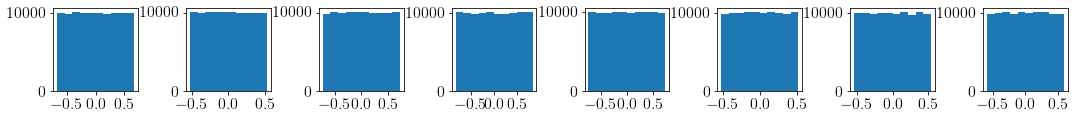

In [68]:
Xs = output[:,0:-1]
Ys = (output[:,-1])

fig, axs = plt.subplots(1,8,figsize=(15,2))
fig.tight_layout()

# n, bins, patches = axs[2,0].hist(Ys,bins=100)

for i in range(8):
    n, bins, patches = axs[i].hist(Xs[:,i],bins=10)

In [80]:
Xs[:,:8].shape

(99999, 8)

You're welcome to train on either the potential or on the potential^1/4. However the "position of the red line" is more obscure in the latter case, because the MAPE error cannot be identified with the error in the potential.

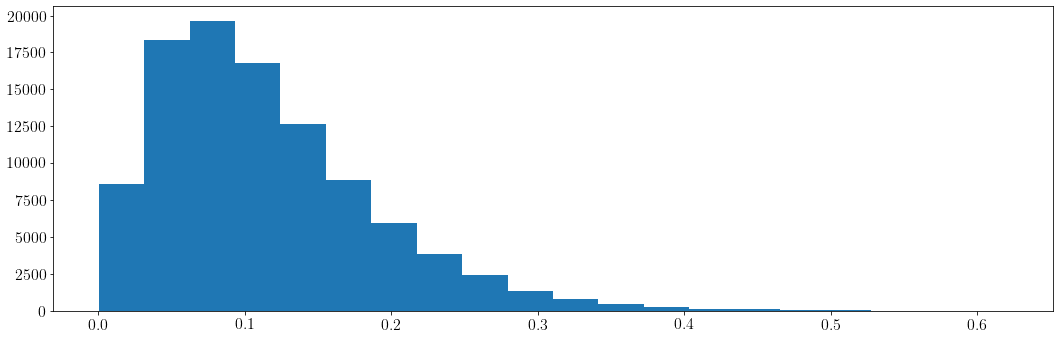

In [86]:
Ys = (output[:,-1])
# Ys = (output[:,-1])**0.25

fig, axs = plt.subplots(1,figsize=(15,5))
fig.tight_layout()
axs.hist(Ys,bins=20)
fig.tight_layout()

# Setting up the NN 

This is stuff you can experiment with, but I have been making use of a few callback options which I have also sometimes modified during training.

In [87]:
from IPython.display import clear_output
import ipywidgets as widgets

from tensorflow import keras
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import layers

# Build in an automatic stop when no improvement is found, restore to best weights
callbackearlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', baseline=None, patience=10, restore_best_weights = True)


class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    
    """
        
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        
        out = widgets.Output(layout={'border': '1px solid black'})
        clear_output(wait=True)
        
        with out:
            for i, metric in enumerate(metrics):
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics[metric], 
                            label=metric
                           )
                axs[i].set_yscale('log')
                if logs['val_' + metric]:
                    axs[i].plot(range(1, epoch + 2),
                                self.metrics['val_' + metric], 
    #                             label='val_' + metric
                               )

                axs[i].legend()
#                 axs[i].grid()
                axs[i].grid(b=True, which='major', linestyle='-')
                axs[i].grid(b=True, which='minor', linestyle='--')

            for i, metric in enumerate(metrics):
                print("")
                print(self.metrics[metric][-1])

            
        plt.tight_layout()
        plt.show()

        
rlop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=.2,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
        
callbacks_list = [PlotLearning(),rlop,callbackearlystop]

I've been using leaky RELU because I worried about dead neurons in my false vacuum

In [91]:


# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
initializer = 'normal'
activ = 'relu'
activ = 'elu'
activ = tf.keras.layers.LeakyReLU(alpha=0.2)
regu = regularizers.l1_l2(l1=1e-5, l2=1e-5)

Xsnew = Xs[:,:]
Ysnew = Ys[:]

inputs=tf.keras.Input(shape=Xsnew.shape[1])
# x = layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(16, input_dim=Xsnew.shape[1], activation=activ)(inputs)
# x = layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(16, activation=activ, kernel_initializer=initializer)(x)
# x = layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=activ, kernel_initializer=initializer)(x)
x = tf.keras.layers.Dense(16, activation=activ, kernel_initializer=initializer)(x)
outputs = tf.keras.layers.Dense(1, activation=activ)(x) # use this for NN without one hot encoding
modelrandom = tf.keras.Model(inputs=inputs,outputs=outputs)

modelrandom.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_35 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_36 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_37 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 977
Trainable params: 977
Non-trainable params: 0
_____________________________________________________________

# Training

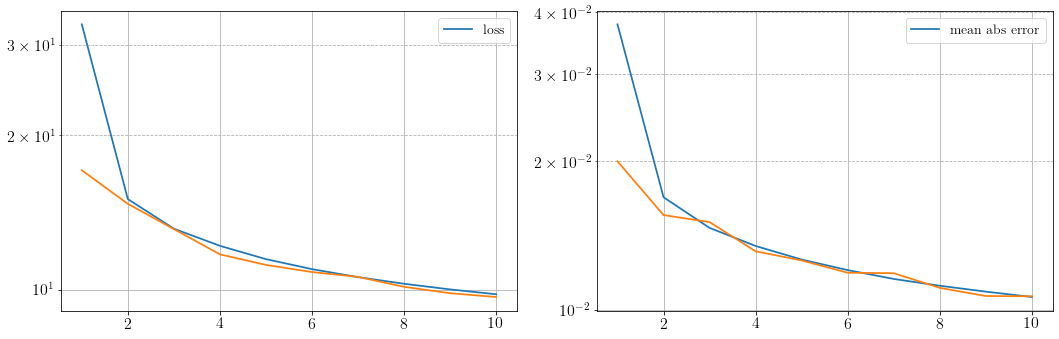

In [92]:
from sklearn.model_selection import train_test_split

# Without one hot encoding
sgdopt=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=.1, nesterov=True, name='SGD')
adamopt=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=.99, epsilon=1e-8, amsgrad=False)
opt=adamopt

import tensorflow.keras.backend as kb

def custom_loss(y_actual,y_pred):
    delta=2
    delta2=1
    eps=1e-5
    yp=kb.pow(eps+y_pred,delta)
    yt=kb.pow(eps+y_actual,delta)
#     custom_loss = delta**(-1)*((yp- yt*kb.log(yp)) - (yt- yt*kb.log(yt)))
    custom_loss = 0.1*((yp- yt*kb.log(yp)) - (yt- yt*kb.log(yt))) + kb.abs(y_pred-y_actual)
#     custom_loss = kb.square(y_pred-y_actual) 
    return custom_loss


# loss1 = tf.keras.losses.Huber(delta=0.1, name='huber_loss')
loss1 = 'mape'
# loss1 = custom_loss


modelrandom.compile(optimizer=opt,loss=loss1,metrics=[tf.keras.metrics.MeanAbsoluteError(name='mean abs error')],run_eagerly=False)
modelrandom.fit(Xsnew,Ysnew,epochs=10,batch_size=8,validation_split = 0.05,verbose=0,use_multiprocessing=True, callbacks=callbacks_list)



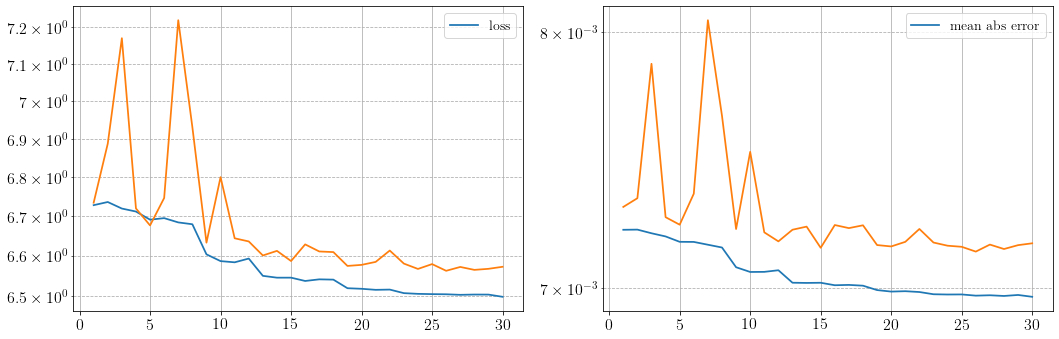

In [95]:
rlop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=.5,
    patience=3,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
        
        
callbacks_list = [PlotLearning(),rlop,callbackearlystop]

for i in range(10):
    
    print(i)

    adamopt=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.75, beta_2=.999, epsilon=1e-8, amsgrad=True)
    opt=adamopt

#     loss1 = tf.keras.losses.LogCosh()
    loss1 = 'mape'
    valsplit=0.05+0.05*random.randint(0, 5)

    modelrandom.compile(optimizer=
                        opt,loss=loss1,metrics=[tf.keras.metrics.MeanAbsoluteError(name='mean abs error')],
                        run_eagerly=False)

    hist=modelrandom.fit(Xsnew,Ysnew,epochs=30,batch_size=128,validation_split = 
                    valsplit, shuffle = True, verbose=0,use_multiprocessing=True, callbacks=callbacks_list)
    

# Testing

## Different epses 

In [96]:
# Checking scaling with epsilon of transformations


number_predictions=1000

transVs=np.zeros(number_predictions)
epses=np.zeros(number_predictions)
transVdiffs=np.zeros(number_predictions)
rotVdiffs=np.zeros(number_predictions)
randvecs=np.zeros((number_predictions,8))
randmeans=np.zeros(number_predictions)

for i in range(number_predictions):
    
    print(i)
    clear_output(wait=True)
    
    eps=10**(2*round(-1.*random.random()+0.25,1))
    random_vector = Xs[random.randint(0, 10000),:]
#     random_vector = df_pions_array[random.randint(0, 10000),0:-2]
    
#     Random rotation
    rotno1=random.randint(0, 7)
    rotno2=random.randint(0, 7)
    while rotno2 == rotno1:
        rotno2=random.randint(0, 7)
    rotesamp=np.zeros((8,8))
    rotesamp[rotno1,rotno2]=1
    rotesamp[rotno2,rotno1]=-1
    detrot=1
    rot_random_vector=detrot**-1*(random_vector+eps*(np.matmul(rotesamp,
                                                   random_vector[:8])))
#     Random transfromation under SU(3) adjoint
    genno=random.randint(0, 7)
    detgen=1
    su3trans = adjointSU3[genno]
    trans_random_vector=detgen**-1*(random_vector+eps*(np.matmul(su3trans,
                                                   random_vector[:8])))
    
    random_vector=np.reshape(random_vector,(1,-1))
    trans_random_vector=np.reshape(trans_random_vector,(1,-1))
    rot_random_vector=np.reshape(rot_random_vector,(1,-1))
    
    random_V = (modelrandom.predict(random_vector))
    rot_random_V = (modelrandom.predict(rot_random_vector))
    trans_random_V = (modelrandom.predict(trans_random_vector))
    
    epses[i]=eps
    transVs[i]=random_V
    transVdiffs[i]=(random_V - trans_random_V)/random_V
    rotVdiffs[i]=(random_V - rot_random_V)/random_V
    randvecs[i]=random_vector
    randmeans[i]=np.mean(np.abs(random_vector))

    
print("Average error of SU(3) transformation: ",np.mean(np.abs(transVdiffs)),
      ", and of rotation: ",np.mean(np.abs(rotVdiffs)))

print("Average potential value: ",np.mean(np.abs(transVs)),", average pion value:",np.mean(randmeans))

Average error of SU(3) transformation:  0.8812826909826399 , and of rotation:  0.6242360110349564
Average potential value:  0.10726328693702816 , average pion value: 0.31889160677280715


/mt/data-grid/dcroon/djuna_env/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mt/data-grid/dcroon/djuna_env/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


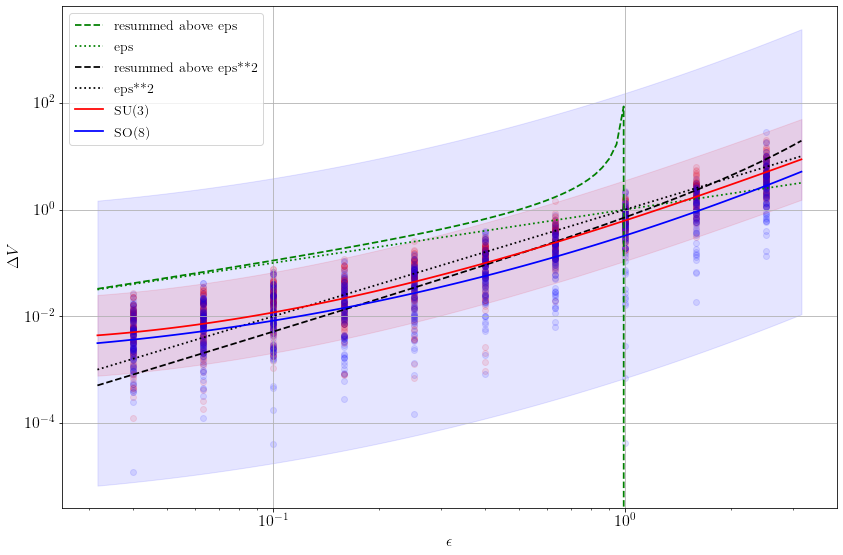

In [97]:
fig,ax = plt.subplots(1,figsize=(12,8))
ax.scatter(epses,np.abs(transVdiffs),color="red", alpha=0.1)
ax.scatter(epses,np.abs(rotVdiffs),color="blue", alpha=0.1)
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\Delta V$')
ax.set_xscale('log')
ax.set_yscale('log')

x = np.logspace(-1.5,0.5,100)
y1 = np.exp(x)-(1+x)
y = 1/(1-x)-(1)
ax.plot(x,y,color="green",linestyle='--',label='resummed above eps')
ax.plot(x,x,color="green",linestyle='dotted',label='eps')
ax.plot(x,y1,color="black",linestyle='--',label='resummed above eps**2')
ax.plot(x,x**2,color="black",linestyle='dotted',label='eps**2')

polyfsu3=np.polyfit(x=np.log(epses.astype(float)), y=np.log(abs(transVdiffs).astype(float)), deg=3)
psu3 = np.polynomial.polynomial.Polynomial(polyfsu3[::-1])
ax.plot(x,np.exp(psu3(np.log(x))), color="red",label='SU(3)')
diffs=np.zeros(number_predictions)
for i in range(number_predictions):
    difs = np.exp(psu3(np.log(epses[i])))-np.abs(transVdiffs[i])
    diffs[i] = difs/np.abs(transVdiffs[i])
su3sd=np.std(diffs)
ax.fill_between(x,1/su3sd*np.exp(psu3(np.log(x))),su3sd*np.exp(psu3(np.log(x))), color="red", alpha=0.1)

polyfrot=np.polyfit(x=np.log(epses.astype(float)), y=np.log(abs(rotVdiffs).astype(float)), deg=3)
prot = np.polynomial.polynomial.Polynomial(polyfrot[::-1])
ax.plot(x,np.exp(prot(np.log(x))), color="blue",label='SO(8)')
diffs=np.zeros(number_predictions)
for i in range(number_predictions):
    difs = np.exp(psu3(np.log(epses[i])))-np.abs(rotVdiffs[i])
    diffs[i] = difs/np.abs(rotVdiffs[i])
rotsd=np.std(diffs)
ax.fill_between(x,1/rotsd*np.exp(prot(np.log(x))),rotsd*np.exp(prot(np.log(x))), color="blue", alpha=0.1)


transeps=np.column_stack(((np.log10(epses)).round(1),(np.log10(np.abs(transVdiffs))).round(1)))
dfepses = pd.DataFrame(data=transeps, columns=["eps", "su3"])
sb.lineplot(data=dfepses, x="eps", y="su3")

plt.yscale('log')
plt.xscale('log')
plt.grid()

ax.legend()
fig.tight_layout()
# fig.savefig('DeltaV.png',dpi=200,transparent=False)

/mt/data-grid/dcroon/djuna_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


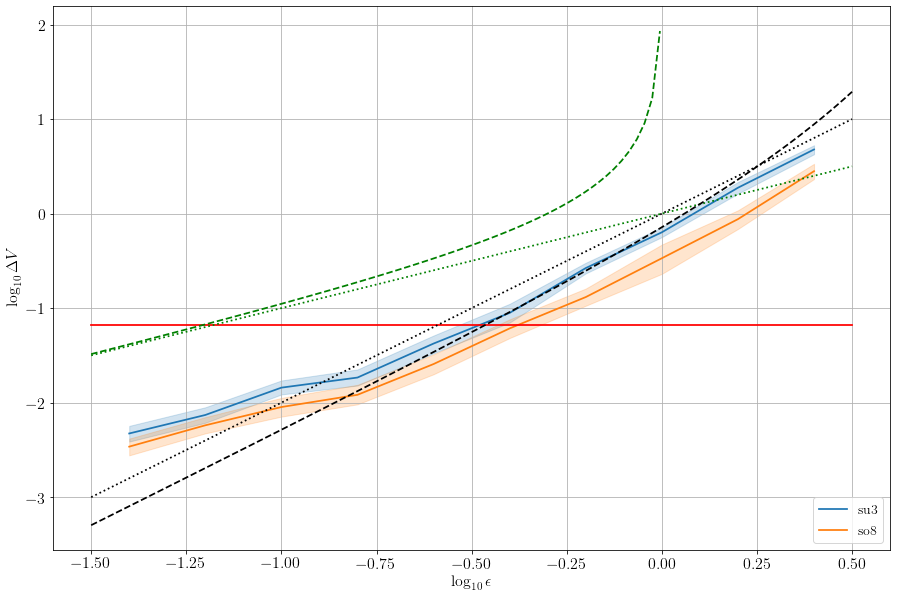

In [98]:
fig = plt.figure(figsize=(15,10))

transeps=np.column_stack(((np.log10(epses)),(np.log10(np.abs(transVdiffs))),(np.log10(np.abs(rotVdiffs)))))
dfepses = pd.DataFrame(data=transeps, columns=["eps", "su3", "so8"])
sb.lineplot(data=dfepses, x="eps", y="su3")
sb.lineplot(data=dfepses, x="eps", y="so8")
plt.legend(title='', loc='lower right', labels=['su3', 'so8'])
plt.grid()
plt.xlabel(r'$\log_{10}\epsilon$')
plt.ylabel(r'$\log_{10}\Delta V$')

x = np.linspace(-1.5,0.5,100)
lastloss= np.log10((hist.history)['val_loss'][-1]*0.01)+0*x
plt.plot(x,lastloss,color="red",linestyle='-',label='loss')

y1 = np.log10(np.exp(10**x)-(1+10**x))
y = np.log10(1/(1-10**x)-(1))
plt.plot(x,y,color="green",linestyle='--',label='resummed above eps')
plt.plot(x,x,color="green",linestyle='dotted',label='eps')
plt.plot(x,y1,color="black",linestyle='--',label='resummed above eps**2')
plt.plot(x,2*x,color="black",linestyle='dotted',label='eps**2')